In [1]:
#import some stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from tqdm import tqdm
import glob
import time
import xgboost as xgb
from sklearn.model_selection import train_test_split #use this?
from scipy import stats
from sklearn.metrics import log_loss, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import GridSearchCV

In [2]:
urlScout = 'https://raw.githubusercontent.com/bigdatacup/Big-Data-Cup-2021/main/hackathon_scouting.csv'
urlWomen = 'https://raw.githubusercontent.com/bigdatacup/Big-Data-Cup-2021/main/hackathon_womens.csv'
dataScout = pd.read_csv(urlScout)
dataWomen = pd.read_csv(urlWomen)

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
dataScout.head(1)

,game_date,Home Team,Away Team,Period,Clock,Home Team Skaters,Away Team Skaters,Home Team Goals,Away Team Goals,Team,Player,Event,X Coordinate,Y Coordinate,Detail 1,Detail 2,Detail 3,Detail 4,Player 2,X Coordinate 2,Y Coordinate 2
0,2019-09-20,Erie Otters,Sudbury Wolves,1,20:00,5,5,0,0,Sudbury Wolves,Blake Murray,Faceoff Win,100,43,Forehand,NaN,NaN,NaN,Connor Lockhart,NaN,NaN


In [5]:
#dataWomen.head(1)

In [6]:
#this will load the xCP model

xCPModel = xgb.Booster({'nthread':4})
xCPModel.load_model('xCPwithDumpInAug_simple.json')

In [7]:
#this will load the xG model

xGModel = xgb.Booster({'nthread':4})
xGModel.load_model('xG_simpleFINAL.json')

In [8]:
#this will load the xPassToPoint model

xPtPModel = xgb.Booster({'nthread':4})
xPtPModel.load_model('xPassToPointNEWAug.json')

In [9]:
def fixDumpsX(row):
    if row['Event'] == 'Dump In/Out':
        if row['NextEvent'] == 'Puck Recovery':
            if row['NextX'] < 75:
                return (200 - row['NextX'])
            else:
                return row['NextX']
        else:
            if row['NextXShift2'] < 75:
                return (200 - row['NextXShift2'])
            else:
                return row['NextXShift2']
    else:
        return row['X Coordinate 2']
    
def fixDumpsY(row):
    if row['Event'] == 'Dump In/Out':
        if row['NextEvent'] == 'Puck Recovery':
            if row['NextX'] < 75:
                return (85 - row['NextY'])
            else:
                return row['NextY']
        else:
            if row['NextXShift2'] < 75:
                return (85 - row['NextYShift2'])
            else:
                return row['NextYShift2']
    else:
        return row['Y Coordinate 2']

def getDataReadyxCP(df):
    df = df.copy()
    df['NextEvent'] = df['Event'].shift(-1)
    df['NextEvent2'] = df['Event'].shift(-2)
    df['NextX'] = df['X Coordinate'].shift(-1)
    df['NextY'] = df['Y Coordinate'].shift(-1)
    df['NextXShift2'] = df['X Coordinate'].shift(-2)
    df['NextYShift2'] = df['Y Coordinate'].shift(-2)
    #filter out dumps that go to goalie
    df = df.loc[((df['Event'] == 'Dump In/Out') & ((df['NextEvent'] == 'Puck Recovery') | (df['NextEvent2'] == 'Puck Recovery'))) | (df['Event'] != 'Dump In/Out')]
    df['X Coordinate 2'] = df.apply(lambda row: fixDumpsX(row),axis=1)
    df['Y Coordinate 2'] = df.apply(lambda row: fixDumpsY(row),axis=1)
    df['isDump'] = df.apply(lambda row: 1 if (row['Event'] == 'Dump In/Out') else 0,axis=1)
    df['isDumpRetained'] = df.apply(lambda row: (row['Detail 1'] == 'Retained'),axis=1)
    
    filteredDF = df.loc[(df['Event'] ==  'Play' ) | (df['Event'] == 'Incomplete Play') | (df['Event'] == 'Dump In/Out')].copy() #only need these rows
    filteredDF['TeamSkaters'] = filteredDF.apply(lambda row: row['Home Team Skaters'] if (row['Team'] == row['Home Team']) else row['Away Team Skaters'],axis=1)
    filteredDF['OppSkaters'] = filteredDF.apply(lambda row: row['Home Team Skaters'] if (row['Team'] == row['Away Team']) else row['Away Team Skaters'],axis=1)
    filteredDF['onPP'] = filteredDF.apply(lambda row: row['TeamSkaters'] > row['OppSkaters'],axis=1)
    filteredDF['onPK'] = filteredDF.apply(lambda row: row['TeamSkaters'] < row['OppSkaters'],axis=1)
    filteredDF['AmountExtraSkaters'] = filteredDF.apply(lambda row: row['TeamSkaters'] - row['OppSkaters'],axis=1)
    filteredDF['CompletePass'] = filteredDF.apply(lambda row: 1 if (row['Event'] == 'Play') else 0,axis=1)
    filteredDF['CompletePass'] = filteredDF.apply(lambda row: 1 if ((row['isDump'] == 1) & row['isDumpRetained'])
                                                  else row['CompletePass'],axis=1)
    filteredDF['passXTravel'] = filteredDF.apply(lambda row: row['X Coordinate 2'] - row['X Coordinate'],axis=1)
    filteredDF['passYTravel'] = filteredDF.apply(lambda row: row['Y Coordinate 2'] - row['Y Coordinate'],axis=1)
    filteredDF['TotalDistance'] = filteredDF.apply(lambda row: (row['passXTravel']**2 + row['passYTravel']**2)**0.5,axis=1)
    #this is for simple model
    filteredDF = filteredDF[['X Coordinate','Y Coordinate','X Coordinate 2','Y Coordinate 2','onPP','onPK','isDump',
                           'passXTravel','passYTravel','TotalDistance','AmountExtraSkaters','CompletePass']]
    X = filteredDF.iloc[:,:-1]
    y = filteredDF.iloc[:,-1]
    return X,y

In [10]:
#here this will help make an xGoals model
def getDataReadyxG(df):
    df = df.copy()
    #this is for the offensive zone xG
    #filteredDF = df.loc[(df['Event'] ==  'Shot' ) | (df['Event'] == 'Goal')].copy() #only need these rows
    filteredDF = df.loc[df['X Coordinate'] >= 125].copy()
    
    filteredDF['TeamSkaters'] = filteredDF.apply(lambda row: row['Home Team Skaters'] if (row['Team'] == row['Home Team']) else row['Away Team Skaters'],axis=1)
    filteredDF['OppSkaters'] = filteredDF.apply(lambda row: row['Home Team Skaters'] if (row['Team'] == row['Away Team']) else row['Away Team Skaters'],axis=1)
    filteredDF['onPP'] = filteredDF.apply(lambda row: 1*((row['TeamSkaters'] > row['OppSkaters']) & (row['OppSkaters'] < 5)),axis=1)
    filteredDF['onPK'] = filteredDF.apply(lambda row: 1*((row['TeamSkaters'] < row['OppSkaters']) & (row['TeamSkaters'] < 5)),axis=1)
    filteredDF['TeamEmptyNet'] = filteredDF.apply(lambda row: 1*(row['TeamSkaters'] > 6),axis=1)
    filteredDF['OppEmptyNet'] = filteredDF.apply(lambda row: 1*(row['OppSkaters'] > 6),axis=1)
    filteredDF['AmountExtraSkaters'] = filteredDF.apply(lambda row: row['TeamSkaters'] - row['OppSkaters'],axis=1)
    filteredDF['Goal'] = filteredDF.apply(lambda row: 1 if (row['Event'] == 'Goal') else 0,axis=1)
    filteredDF['DistanceToCenterGoal'] = filteredDF.apply(lambda row: ((189 - row['X Coordinate'])**2 + (42.5 - row['Y Coordinate'])**2)**0.5,axis=1)
    def getAreaNet(x,y):
        if y > 42.5:
            y = 85 - y #so it's like we're on the bottom side of the rink - mirror doesn't matter
        hyp = ((189 - x)**2 + (39.5 - y)**2)**0.5
        vector1 = [189 - x, 39.5 - y]
        vector2 = [189 - x, 45.5 - y]
        unit_vector_1 = vector1 / np.linalg.norm(vector1)
        unit_vector_2 = vector2 / np.linalg.norm(vector2)
        dot_product = np.dot(unit_vector_1, unit_vector_2)
        angle = np.arccos(dot_product)
        angle = angle / 2 #using angle bisector for triangle
        halfNet = np.sin(angle) * hyp
        fullNet = 2 * halfNet
        return fullNet*4
    filteredDF['SurfaceAreaNetSeen'] = filteredDF.apply(lambda row: getAreaNet(row['X Coordinate'],row['Y Coordinate']),axis=1)
    filteredDF = filteredDF[['onPP','onPK','TeamEmptyNet','OppEmptyNet','AmountExtraSkaters','DistanceToCenterGoal','SurfaceAreaNetSeen','Goal']]
    X = filteredDF.iloc[:,:-1]
    y = filteredDF.iloc[:,-1]
    return X,y

In [11]:
def getDataReadyxGNeutral(df):
    df = df.copy()
    df = df.loc[(df['X Coordinate'] > 75) & (df['X Coordinate'] < 125)]
    df['TeamSkaters'] = df.apply(lambda row: row['Home Team Skaters'] if (row['Team'] == row['Home Team']) else row['Away Team Skaters'],axis=1)
    df['OppSkaters'] = df.apply(lambda row: row['Home Team Skaters'] if (row['Team'] == row['Away Team']) else row['Away Team Skaters'],axis=1)
    df['onPP'] = df.apply(lambda row: 1*((row['TeamSkaters'] > row['OppSkaters']) & (row['OppSkaters'] < 5)),axis=1)
    df['onPK'] = df.apply(lambda row: 1*((row['TeamSkaters'] < row['OppSkaters']) & (row['TeamSkaters'] < 5)),axis=1)
    df['TeamEmptyNet'] = df.apply(lambda row: 1*(row['TeamSkaters'] > 6),axis=1)
    df['OppEmptyNet'] = df.apply(lambda row: 1*(row['OppSkaters'] > 6),axis=1)
    df['AmountExtraSkaters'] = df.apply(lambda row: row['TeamSkaters'] - row['OppSkaters'],axis=1)
    #isDump may need to be changed on where x2 and y2 are
    df['isDump'] = df.apply(lambda row: 1 if (row['Event'] == 'Dump In/Out') else 0,axis=1)
    #this is for simple model
    df = df[['X Coordinate','Y Coordinate','onPP','onPK','TeamEmptyNet','OppEmptyNet','isDump','AmountExtraSkaters']]
    return df

In [12]:
def getDataReadyxGDefensive(df):
    df = df.copy()
    df = df.loc[(df['X Coordinate'] <= 75)]
    df['TeamSkaters'] = df.apply(lambda row: row['Home Team Skaters'] if (row['Team'] == row['Home Team']) else row['Away Team Skaters'],axis=1)
    df['OppSkaters'] = df.apply(lambda row: row['Home Team Skaters'] if (row['Team'] == row['Away Team']) else row['Away Team Skaters'],axis=1)
    df['onPP'] = df.apply(lambda row: 1*((row['TeamSkaters'] > row['OppSkaters']) & (row['OppSkaters'] < 5)),axis=1)
    df['onPK'] = df.apply(lambda row: 1*((row['TeamSkaters'] < row['OppSkaters']) & (row['TeamSkaters'] < 5)),axis=1)
    df['TeamEmptyNet'] = df.apply(lambda row: 1*(row['TeamSkaters'] > 6),axis=1)
    df['OppEmptyNet'] = df.apply(lambda row: 1*(row['OppSkaters'] > 6),axis=1)
    df['AmountExtraSkaters'] = df.apply(lambda row: row['TeamSkaters'] - row['OppSkaters'],axis=1)
    #isDump may need to be changed on where x2 and y2 are
    df['isDump'] = df.apply(lambda row: 1 if (row['Event'] == 'Dump In/Out') else 0,axis=1)
    #this is for simple model
    df = df[['X Coordinate','Y Coordinate','onPP','onPK','TeamEmptyNet','OppEmptyNet','isDump','AmountExtraSkaters']]
    return df

In [13]:
#Xg,yg = getDataReadyxG(dataScout)

In [14]:
len(dataScout.loc[(dataScout['X Coordinate'] <= 75) & (dataScout['Event'] == 'Dump In/Out')])

1842

In [15]:
#Xcp,ycp = getDataReadyxCP(dataScout)

In [16]:
readyDF = getDataReadyxGNeutral(dataScout)

In [17]:
def getDist(x1,x2):
    return (x2-x1)
def get2dDist(xdist,ydist):
    return (xdist**2 + ydist**2)**0.5
def distToCenterGoal(x,y):
    return ((189 - x)**2 + (42.5 - y)**2)**0.5
def getAreaNet(x,y):
    if y > 42.5:
        y = 85 - y #so it's like we're on the bottom side of the rink - mirror doesn't matter
    if x > 189:
        return 0
    else:
        hyp = ((189 - x)**2 + (39.5 - y)**2)**0.5
        vector1 = [189 - x, 39.5 - y]
        vector2 = [189 - x, 45.5 - y]
        unit_vector_1 = vector1 / np.linalg.norm(vector1)
        unit_vector_2 = vector2 / np.linalg.norm(vector2)
        dot_product = np.dot(unit_vector_1, unit_vector_2)
        angle = np.arccos(dot_product)
        angle = angle / 2 #using angle bisector for triangle
        halfNet = np.sin(angle) * hyp
        fullNet = 2 * halfNet
        return fullNet*4
#this assumes input df is just the events in neutral zone
def getxGNeutralhelper(row,xy_grid):
    xCPList = []
    xGList = []
    for x,y in xy_grid:
        xdist = getDist(row['X Coordinate'],x)
        ydist = getDist(row['Y Coordinate'],y)
        xCPList.append([row['X Coordinate'],row['Y Coordinate'],x,y,row['onPP'],row['onPK'],1*(x > 189),
                                 xdist,ydist,get2dDist(xdist,ydist),row['AmountExtraSkaters']])
        xGList.append([row['onPP'],row['onPK'],row['TeamEmptyNet'],row['OppEmptyNet'],row['AmountExtraSkaters'],
                       distToCenterGoal(x,y),getAreaNet(x,y)])
    xCPdf = pd.DataFrame(xCPList,columns=['X Coordinate','Y Coordinate','X Coordinate 2','Y Coordinate 2','onPP','onPK',
                                            'isDump','passXTravel','passYTravel','TotalDistance','AmountExtraSkaters'])
    xGdf = pd.DataFrame(xGList,columns=['onPP','onPK','TeamEmptyNet','OppEmptyNet','AmountExtraSkaters','DistanceToCenterGoal','SurfaceAreaNetSeen'])
    dtestxCP = xgb.DMatrix(xCPdf)
    xCP_predictions = xCPModel.predict(dtestxCP).tolist()
    dtestxG = xgb.DMatrix(xGdf)
    xG_predictions = xGModel.predict(dtestxG).tolist()
    #xPtP and xCP use same columns
    
    #I'm just saying everything is on bottom of ice
    xCPdf['Y Coordinate'] = xCPdf.apply(lambda row: (85 - row['Y Coordinate']) if (row['Y Coordinate'] > 42)
                                       else row['Y Coordinate'],axis=1)
    xCPdf['Y Coordinate 2'] = xCPdf.apply(lambda row: (85 - row['Y Coordinate 2']) if (row['Y Coordinate 2'] > 42)
                                       else row['Y Coordinate 2'],axis=1)
    dtestxPtP = xgb.DMatrix(xCPdf)
    xPtP_predictions = xPtPModel.predict(dtestxPtP).tolist()
    predsum = sum(xPtP_predictions) #21.84 
    newxPtPpreds = [ele/predsum for ele in xPtP_predictions]
    xG = 0
    for n1,n2,n3 in zip(xCP_predictions,xG_predictions,newxPtPpreds):
        xG += (n1*n2*n3)
    return xG

In [18]:
testDF= readyDF.copy()

In [24]:
%%time

xy_grid = [(5*x,5*y) for x in range(26,40) for y in range(17)]
testDF['xG'] = testDF.apply(lambda row: getxGNeutralhelper(row,xy_grid),axis=1)

Wall time: 24min 24s


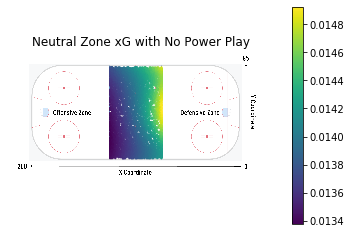

In [25]:
nonPPorDump = testDF.loc[(testDF['AmountExtraSkaters'] == 0) & (testDF['isDump'] == 0)]
plt.figure()
plt.scatter(nonPPorDump['X Coordinate'].tolist(),nonPPorDump['Y Coordinate'].tolist(),c=nonPPorDump['xG'].tolist(),s=1,cmap='viridis')
#plt.gray()
plt.colorbar()
plt.title("Neutral Zone xG with No Power Play")
rinkPath = 'https://raw.githubusercontent.com/bigdatacup/Big-Data-Cup-2021/main/rink_coords.png'
im = plt.imread(rinkPath)
plt.imshow(im,extent=(-20,230,-20,100))
plt.axis('off')
plt.show()

In [26]:
def xCPhelp(row1,xy_grid):
    xCPList = []
    for x,y in xy_grid:
        row = row1.iloc[0]
        xdist = getDist(row['X Coordinate'],x)
        ydist = getDist(row['Y Coordinate'],y)
        xCPList.append([row['X Coordinate'],row['Y Coordinate'],x,y,row['onPP'],row['onPK'],1*(x > 189),
                                 xdist,ydist,get2dDist(xdist,ydist),row['AmountExtraSkaters']])
    xCPdf = pd.DataFrame(xCPList,columns=['X Coordinate','Y Coordinate','X Coordinate 2','Y Coordinate 2','onPP','onPK',
                                            'isDump','passXTravel','passYTravel','TotalDistance','AmountExtraSkaters'])
    dtestxCP = xgb.DMatrix(xCPdf)
    xCP_predictions = xCPModel.predict(dtestxCP).tolist()
    xCPdf['xCP'] = xCP_predictions
    return xCPdf

In [27]:
xcptest = readyDF.copy()
xcptest = xcptest[10:11]
xcptest = xCPhelp(xcptest,xy_grid)

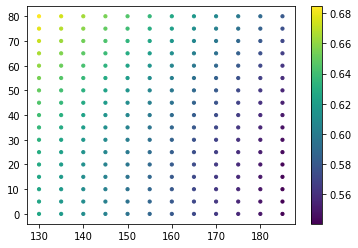

In [28]:
nonPPorDump = xcptest.loc[(xcptest['AmountExtraSkaters'] == 0) & (xcptest['isDump'] == 0)]
plt.figure()
plt.scatter(nonPPorDump['X Coordinate 2'].tolist(),nonPPorDump['Y Coordinate 2'].tolist(),c=nonPPorDump['xCP'].tolist(),s=10,cmap='viridis')
#plt.gray()
plt.colorbar()
#plt.title("with variable normalizer")
plt.show()

In [29]:
%%time 
neutralZonexG = {}
for i in range(len(testDF)):
    row = testDF.iloc[i]
    neutralZonexG['('+str(row['X Coordinate'])+','+str(row['Y Coordinate'])+','+str(row['onPP'])+','+
            str(row['onPK'])+','+str(row['TeamEmptyNet'])+','+str(row['OppEmptyNet'])+','+
            str(row['isDump'])+','+str(row['AmountExtraSkaters'])+')'] = row['xG']

Wall time: 6.35 s


In [30]:
len(neutralZonexG)

6202

In [54]:
#this assumes input df is just the events in defensive zone
def getxGDefensivehelper(row,xy_grid,neutralZonexG,):
    xCPList = []
    xGList = []
    xGNegList = []
    for x,y in xy_grid:
        xdist = getDist(row['X Coordinate'],x)
        ydist = getDist(row['Y Coordinate'],y)
        xCPList.append([row['X Coordinate'],row['Y Coordinate'],x,y,row['onPP'],row['onPK'],1*(x > 189),
                                 xdist,ydist,get2dDist(xdist,ydist),row['AmountExtraSkaters']])
        try:
            xGList.append(neutralZonexG['('+str(x)+','+str(y)+','+
                                        str(row['onPP'])+','+str(row['onPK'])+','+str(row['TeamEmptyNet'])+
                                        ','+str(row['OppEmptyNet'])+','+str(row['isDump'])+','+
                                        str(row['AmountExtraSkaters'])+')'])
        except Exception as err:
            firstrow = [[x,y,row['onPP'],row['onPK'],row['TeamEmptyNet'],row['OppEmptyNet'],row['isDump'],
                        row['AmountExtraSkaters']]]
            tempdf = pd.DataFrame(firstrow,columns=['X Coordinate','Y Coordinate','onPP','onPK',
                                            'TeamEmptyNet','OppEmptyNet','isDump','AmountExtraSkaters'])
            xy_gridNeutral = [(5*x,5*y) for x in range(26,40) for y in range(17)]
            tempdf['xG'] = tempdf.apply(lambda row: getxGNeutralhelper(row,xy_gridNeutral),axis=1)
            xGList.append(tempdf.loc[0,'xG'])
            #xGList.append(tempdf.apply(lambda row: getxGNeutralhelper(row,xy_gridNeutral),axis=1)[1])
            #xGList.append(0.014)
        try:
            xGNegList.append(neutralZonexG['('+str(x)+','+str(y)+','+
                                        str(row['onPK'])+','+str(row['onPP'])+','+str(row['OppEmptyNet'])+
                                        ','+str(row['TeamEmptyNet'])+','+str(row['isDump'])+','+
                                        str(-1*row['AmountExtraSkaters'])+')'])
        except Exception as err:
            firstrow = [[x,y,row['onPK'],row['onPP'],row['OppEmptyNet'],row['TeamEmptyNet'],row['isDump'],
                        -1*row['AmountExtraSkaters']]]
            tempdf = pd.DataFrame(firstrow,columns=['X Coordinate','Y Coordinate','onPP','onPK',
                                            'TeamEmptyNet','OppEmptyNet','isDump','AmountExtraSkaters'])
            xy_gridNeutral = [(5*x,5*y) for x in range(26,40) for y in range(17)]
            tempdf['xG'] = tempdf.apply(lambda row: getxGNeutralhelper(row,xy_gridNeutral),axis=1)
            xGNegList.append(tempdf.loc[0,'xG'])
            #xGNegList.append(tempdf.apply(lambda row: getxGNeutralhelper(row,xy_gridNeutral),axis=1))
            #xGList.append(0.014)
        
        
    xCPdf = pd.DataFrame(xCPList,columns=['X Coordinate','Y Coordinate','X Coordinate 2','Y Coordinate 2','onPP','onPK',
                                            'isDump','passXTravel','passYTravel','TotalDistance','AmountExtraSkaters'])
    #xGdf = pd.DataFrame(xGList,columns=['onPP','onPK','TeamEmptyNet','OppEmptyNet','AmountExtraSkaters','DistanceToCenterGoal','SurfaceAreaNetSeen'])
    dtestxCP = xgb.DMatrix(xCPdf)
    xCP_predictions = xCPModel.predict(dtestxCP).tolist()
    #dtestxG = xgb.DMatrix(xGdf)
    #xG_predictions = xGModel.predict(dtestxG).tolist()
    #xPtP and xCP use same columns
    
    #I'm just saying everything is on bottom of ice for the pass to point model
    xCPdf['Y Coordinate'] = xCPdf.apply(lambda row: (85 - row['Y Coordinate']) if (row['Y Coordinate'] > 42)
                                       else row['Y Coordinate'],axis=1)
    xCPdf['Y Coordinate 2'] = xCPdf.apply(lambda row: (85 - row['Y Coordinate 2']) if (row['Y Coordinate 2'] > 42)
                                       else row['Y Coordinate 2'],axis=1)
    dtestxPtP = xgb.DMatrix(xCPdf)
    xPtP_predictions = xPtPModel.predict(dtestxPtP).tolist()
    predsum = sum(xPtP_predictions) #21.84 
    newxPtPpreds = [ele/predsum for ele in xPtP_predictions]
    xG = 0
    for n1,n2,n3 in zip(xCP_predictions,xGList,newxPtPpreds):
        xG += (n1*n2*n3)
    #now if pass is intercepted
    xCP_predictionsNeg = [(1-i) for i in xCP_predictions]
    for n1,n2,n3 in zip(xCP_predictionsNeg,xGNegList,newxPtPpreds):
        xG += (n1*n2*n3)
    return xG

In [35]:
readyDFDefensive = getDataReadyxGDefensive(dataScout)

In [55]:
testDFDefensive = readyDFDefensive.copy()

In [47]:
def tempapply(row):
    #print(row['onPP'])
    return 4
mytempapply = readyDFDefensive[:1].copy()
print(mytempapply.apply(lambda row: tempapply(row),axis=1)[1])

4


In [ ]:
%%time

xy_gridDefense = [(5*x,5*y) for x in range(16,24) for y in range(17)]
testDFDefensive['xG'] = testDFDefensive.apply(lambda row: getxGDefensivehelper(row,xy_gridDefense,neutralZonexG),axis=1)

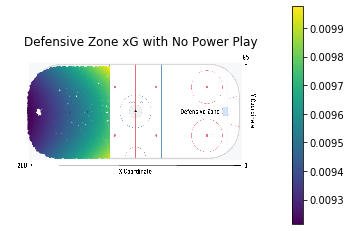

In [216]:
nonPPorDump2 = testDFDefensive.loc[(testDFDefensive['AmountExtraSkaters'] == 0) & (testDFDefensive['isDump'] == 0)]
plt.figure()
plt.scatter(nonPPorDump2['X Coordinate'].tolist(),nonPPorDump2['Y Coordinate'].tolist(),c=nonPPorDump2['xG'].tolist(),s=1,cmap='viridis')
#plt.gray()
plt.colorbar()
plt.title("Defensive Zone xG with No Power Play")
rinkPath = 'https://raw.githubusercontent.com/bigdatacup/Big-Data-Cup-2021/main/rink_coords.png'
im = plt.imread(rinkPath)
plt.imshow(im,extent=(-20,230,-20,100))
plt.axis('off')
plt.show()

In [19]:
testDFOffensive,ydfOffensive = getDataReadyxG(dataScout)

In [20]:
dtestxG = xgb.DMatrix(testDFOffensive)
xG_predictions = xGModel.predict(dtestxG).tolist()
testDFOffensive['xG'] = xG_predictions

In [229]:
testDFOffensive2 = testDFOffensive[['xG']].copy()
testDFDefensive2 = testDFDefensive[['xG']].copy()
testDF2 = testDF[['xG']].copy()

In [230]:
allxG = pd.concat([testDFOffensive2,testDFDefensive2,testDF2])

In [231]:
allxG

,xG
15,0.060578
16,0.073809
17,0.050916
18,0.021758
19,0.012927
...,...
75838,0.014227
75839,0.014227
75843,0.013767
75844,0.014607


In [234]:
dataScoutwithxG = dataScout.merge(allxG,left_index=True,right_index=True)

In [236]:
dataScoutwithxG.to_csv('dataScoutwithxG.csv')

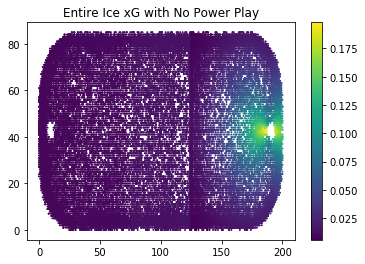

In [246]:
plotxG = dataScoutwithxG.loc[(dataScoutwithxG['Home Team Skaters'] == dataScoutwithxG['Away Team Skaters'])].copy()
plt.figure()
plt.scatter(plotxG['X Coordinate'].tolist(),plotxG['Y Coordinate'].tolist(),c=plotxG['xG'].tolist(),s=1,cmap='viridis')
#plt.gray()
plt.colorbar()
plt.title("Entire Ice xG with No Power Play")
#rinkPath = 'https://raw.githubusercontent.com/bigdatacup/Big-Data-Cup-2021/main/rink_coords.png'
#im = plt.imread(rinkPath)
#plt.imshow(im,extent=(-20,230,-20,100))
#plt.axis('off')
plt.show()

In [21]:
plotxG = dataScoutwithxG.loc[(dataScoutwithxG['Home Team Skaters'] == dataScoutwithxG['Away Team Skaters'])].copy()
plotxG = plotxG.loc[plotxG['X Coordinate'] > 125]
plt.figure()
plt.scatter(plotxG['X Coordinate'].tolist(),plotxG['Y Coordinate'].tolist(),c=plotxG['xG'].tolist(),s=1,cmap='viridis')
#plt.gray()
plt.colorbar()
plt.title("Offensive Zone xG with No Power Play")
#rinkPath = 'https://raw.githubusercontent.com/bigdatacup/Big-Data-Cup-2021/main/rink_coords.png'
#im = plt.imread(rinkPath)
#plt.imshow(im,extent=(-20,230,-20,100))
#plt.axis('off')
plt.show()

KeyError: 'Home Team Skaters'

In [22]:
testDFOffensive

,onPP,onPK,TeamEmptyNet,OppEmptyNet,AmountExtraSkaters,DistanceToCenterGoal,SurfaceAreaNetSeen,xG
15,0,0,0,0,0,29.347061,21.237469,0.060622
16,0,0,0,0,0,18.821530,13.644713,0.074061
17,0,0,0,0,0,22.005681,7.744137,0.051132
18,0,0,0,0,0,34.557922,1.278200,0.021846
19,0,0,0,0,0,61.491869,21.008761,0.012885
...,...,...,...,...,...,...,...,...
75868,0,0,0,0,1,43.200116,6.249873,0.012413
75869,0,0,0,0,1,35.850384,3.091139,0.015667
75870,0,0,0,0,1,19.906029,4.202813,0.035316
75871,0,0,0,0,1,52.690132,23.470751,0.015483
